0.6818181818181818


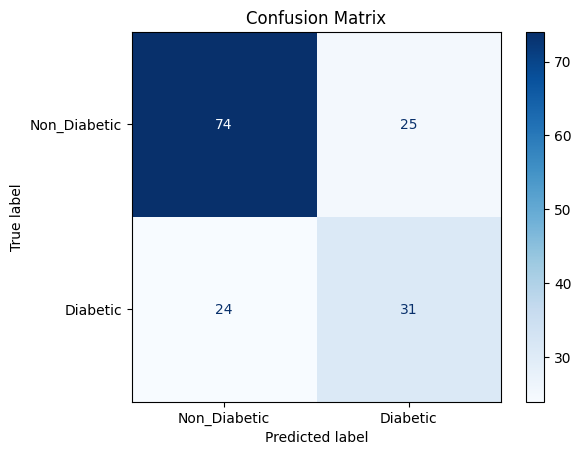

In [3]:
#import sklearn as sk  
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn import ensemble as en
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
#from sklearn.tree import export_text

np.random.seed(2024)
diabetes = pd.read_csv('diabetes_preprocessed.csv')

y = diabetes.get('Outcome').values
X = diabetes.drop(axis='columns', columns ='Outcome').values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

#print(X)
#print(y)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

#r=export_text(clf)
#print(r)

accuracy = accuracy_score(y_test, y_pred) # accuracy score using a single decision tree
# >>> ca. 0.688
print(accuracy)
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Non_Diabetic', 'Diabetic'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

##SOMETHING SOMETHING GINI INDEX

0.7662337662337663


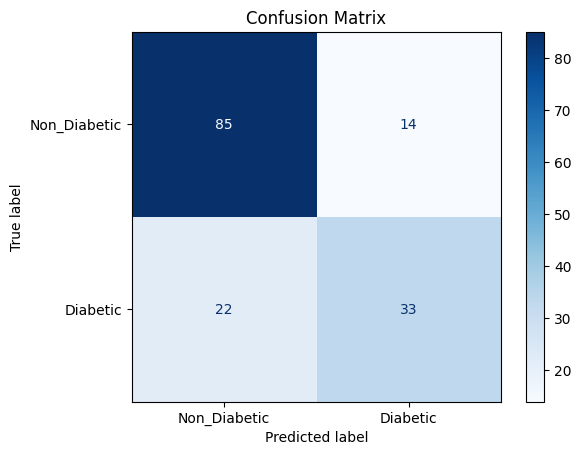

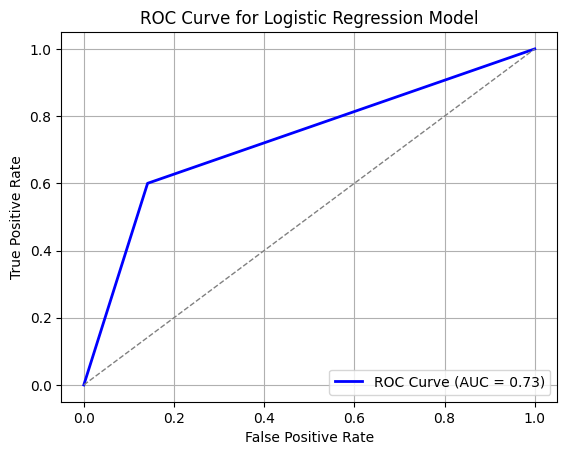

In [4]:
random_forest = en.RandomForestClassifier()

random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred) 
print(accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Non_Diabetic', 'Diabetic'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ROC AUC Plot
# Use predicted probabilities for the positive class (1)
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression Model")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [5]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb


rf = RandomForestClassifier(
    n_estimators=100,      # Number of trees in the forest
    max_depth=6,           # Maximum depth of each tree
    random_state=42        # Seed for reproducibility
)

xgb_clf = xgb.XGBClassifier(
    n_estimators=100,      # Number of boosting rounds
    learning_rate=0.1,     # Learning rate
    max_depth=3,           # Maximum depth of the individual estimators
    random_state=42        # Seed for reproducibility
)

# Create a Logistic Regression model as the meta-classifier
meta_clf = LogisticRegression(random_state=42)
#meta_clf = en.RandomForestClassifier()

# Combine the models using StackingClassifier
stacked_clf = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb_clf)],
    final_estimator=meta_clf,
    cv=10                   # Number of cross-validation folds
)

# Train the stacked model
stacked_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = stacked_clf.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


# Why logreg is best as meta-classifier: https://thesai.org/Downloads/Volume13No10/Paper_39-Performance_Comparison_between_Meta_classifier_Algorithms.pdf 
# display version
#print(xgboost.__version__)
# https://machinelearningmastery.com/random-forest-ensembles-with-xgboost/
# https://www.run.ai/guides/hyperparameter-tuning
# https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/week46.html#what-is-boosting-additive-modelling-iterative-fitting
# https://aws.amazon.com/what-is/boosting/


Accuracy: 76.62%


Accuracy on the test set: 78.57%


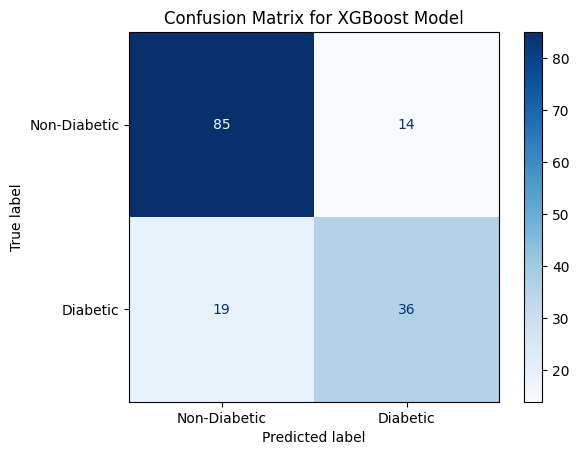

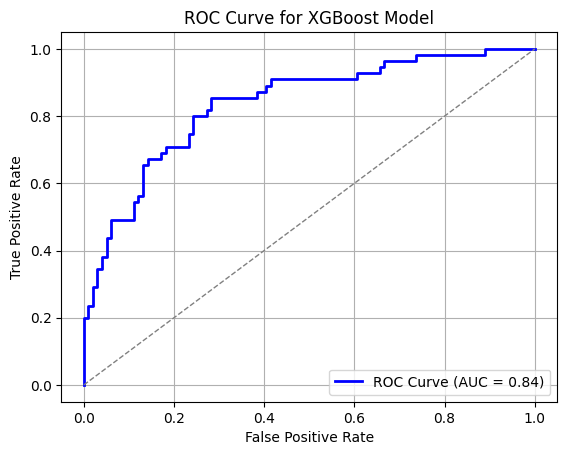

In [6]:
### XGB Boost ###

from xgboost import XGBClassifier, XGBRFClassifier
import logistic_regression as logreg

# Train an XGBoost Classifier
xgb_model = XGBClassifier(
    objective="binary:logistic",
    learning_rate=0.1,    # Try different values, e.g., 0.01, 0.1, 0.2
    n_estimators=100,     # Number of boosting rounds
    max_depth=3,          # Depth of each tree
    random_state=2024,    # Ensure reproducibility
    use_label_encoder=False  # Avoid warnings
)
xgb_model.fit(X_train, y_train)

# Generate predictions
y_pred_test = xgb_model.predict(X_test)
y_pred_prob_test = xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# Evaluate the model
test_accuracy = logreg.calculate_accuracy(y_test, y_pred_test)
print(f"Accuracy on the test set: {test_accuracy * 100:.2f}%")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Non-Diabetic', 'Diabetic'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for XGBoost Model")
plt.show()

# ROC AUC Plot
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for XGBoost Model")
plt.legend(loc="lower right")
plt.grid()
plt.show()

Accuracy on the test set: 90.26%


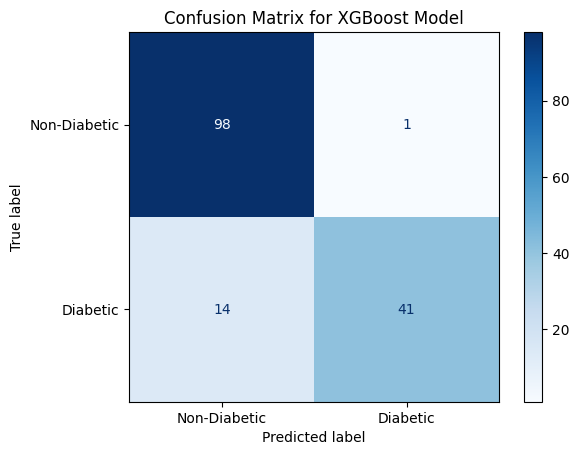

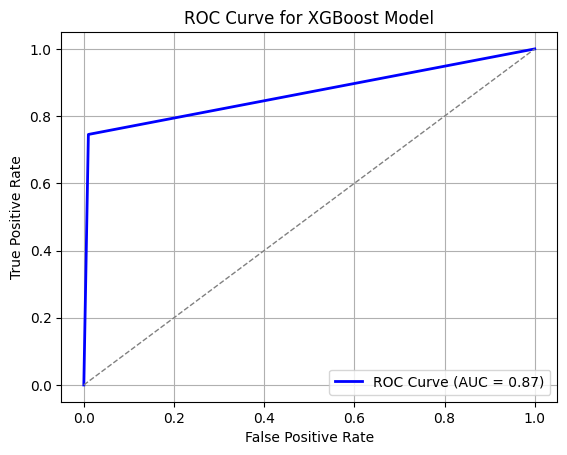

In [15]:
from numpy import mean, std

model = XGBRFClassifier(n_estimators=100, subsample=0.9, colsample_bynode=0.2)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

model.fit(X_test, y_test)

y_pred = model.predict(X_test)

#"""
test_accuracy = logreg.calculate_accuracy(y_test, y_pred)
print(f"Accuracy on the test set: {test_accuracy * 100:.2f}%")

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Non-Diabetic', 'Diabetic'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for XGBoost Model")
plt.show()

#"""
# ROC AUC Plot

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for XGBoost Model")
plt.legend(loc="lower right")
plt.grid()
plt.show()
#"""